This is an implementation of the paper Deep Bayesian Active Learning with Image Data using PyTorch and modAL. 

modAL is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

Since modAL only supports sklearn models, we will also use [skorch](https://skorch.readthedocs.io/en/stable/), a scikit-learn compatible neural network library that wraps PyTorch. 

In [103]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner

### architecture of the network we will be using

We will use the architecture described in the paper.

In [149]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                                nn.Conv2d(1,32,4),
                                nn.ReLU(),
                                nn.Conv2d(32,32,4),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Dropout(0.25)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(11*11*32,128),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out

### read training data

In [6]:
mnist_train = MNIST('.', train=True, download=True, transform=ToTensor())
mnist_test  = MNIST('.', train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

0it [00:00, ?it/s]

9920512it [00:03, 2906822.66it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 42333.82it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 770061.63it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 15859.84it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### preprocessing

In [38]:
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

### initial labelled data
We initialize the labelled set with 20 balanced randomly sampled examples

In [39]:
initial_idx = np.array([],dtype=np.int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

### initial unlabelled pool

In [40]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Query Strategies

### Uniform
All the acquisition function we will use will be compared to the uniform acquisition function $\mathbb{U}_{[0,1]}$ which will be our baseline that we would like to beat.

In [12]:
def uniform(learner, X, n_instances=1):
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

### Entropy
Our first acquisition function is the entropy:
$$ \mathbb{H} = - \sum_{c} p_c \log(p_c)$$
where $p_c$ is the probability predicted for class c. This is approximated by:
\begin{align}
p_c &= \frac{1}{T} \sum_t p_{c}^{(t)} 
\end{align}
where $p_{c}^{t}$ is the probability predicted for class c at the t th feedforward pass.

In [148]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    acquisition = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

In [173]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]    

### Active Learning Procedure

In [121]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [154]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_perf_hist = active_learning_procedure(max_entropy,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.6002
Accuracy after query 2: 0.6314
Accuracy after query 3: 0.6636
Accuracy after query 4: 0.6945
Accuracy after query 5: 0.6981
Accuracy after query 6: 0.7165
Accuracy after query 7: 0.7556
Accuracy after query 8: 0.7810
Accuracy after query 9: 0.7738
Accuracy after query 10: 0.7904
Accuracy after query 11: 0.7589
Accuracy after query 12: 0.8249
Accuracy after query 13: 0.8057
Accuracy after query 14: 0.8220
Accuracy after query 15: 0.8549
Accuracy after query 16: 0.8738
Accuracy after query 17: 0.8557
Accuracy after query 18: 0.8745
Accuracy after query 19: 0.8963
Accuracy after query 20: 0.8979
Accuracy after query 21: 0.9054
Accuracy after query 22: 0.8972
Accuracy after query 23: 0.8974
Accuracy after query 24: 0.8944
Accuracy after query 25: 0.9206
Accuracy after query 26: 0.9051
Accuracy after query 27: 0.9279
Accuracy after query 28: 0.9249
Accuracy after query 29: 0.9343
Accuracy after query 30: 0.9377
Accuracy after query 31: 0.9297
Accuracy after qu

In [174]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
bald_perf_hist = active_learning_procedure(bald,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)

Accuracy after query 1: 0.6155
Accuracy after query 2: 0.6817
Accuracy after query 3: 0.7019
Accuracy after query 4: 0.6774
Accuracy after query 5: 0.7130
Accuracy after query 6: 0.7266
Accuracy after query 7: 0.7136
Accuracy after query 8: 0.7485
Accuracy after query 9: 0.7254
Accuracy after query 10: 0.7325
Accuracy after query 11: 0.7155
Accuracy after query 12: 0.7153
Accuracy after query 13: 0.7647
Accuracy after query 14: 0.8088
Accuracy after query 15: 0.7760
Accuracy after query 16: 0.8224
Accuracy after query 17: 0.8514
Accuracy after query 18: 0.8600
Accuracy after query 19: 0.8596
Accuracy after query 20: 0.8559
Accuracy after query 21: 0.9251
Accuracy after query 22: 0.9296
Accuracy after query 23: 0.9233
Accuracy after query 24: 0.9220
Accuracy after query 25: 0.9202
Accuracy after query 26: 0.9218
Accuracy after query 27: 0.9258
Accuracy after query 28: 0.9292
Accuracy after query 29: 0.9380
Accuracy after query 30: 0.9430
Accuracy after query 31: 0.9320
Accuracy after qu

In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
uniform_perf_hist = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.5799
Accuracy after query 2: 0.6213
Accuracy after query 3: 0.6573
Accuracy after query 4: 0.7146
Accuracy after query 5: 0.6983
Accuracy after query 6: 0.7362
Accuracy after query 7: 0.7681
Accuracy after query 8: 0.7707
Accuracy after query 9: 0.7912
Accuracy after query 10: 0.7993
Accuracy after query 11: 0.8199
Accuracy after query 12: 0.8161
Accuracy after query 13: 0.8257
Accuracy after query 14: 0.8534
Accuracy after query 15: 0.8481
Accuracy after query 16: 0.8582
Accuracy after query 17: 0.8525
Accuracy after query 18: 0.8571
Accuracy after query 19: 0.8671
Accuracy after query 20: 0.8651
Accuracy after query 21: 0.7627
Accuracy after query 22: 0.8604
Accuracy after query 23: 0.8706
Accuracy after query 24: 0.8749
Accuracy after query 25: 0.8895
Accuracy after query 26: 0.8922
Accuracy after query 27: 0.8944
Accuracy after query 28: 0.8953
Accuracy after query 29: 0.8919
Accuracy after query 30: 0.8980
Accuracy after query 31: 0.9005
Accuracy after qu

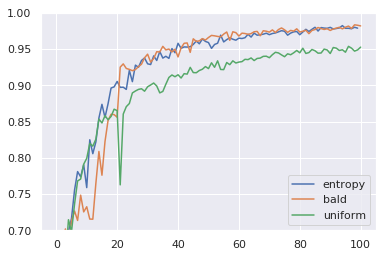

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(entropy_perf_hist, label="entropy")
plt.plot(bald_perf_hist, label="bald")
plt.plot(uniform_perf_hist, label="uniform")
plt.ylim([0.7,1])
plt.legend()